In [1]:
# this file is for BiLSTM - CNN - CRF 
# crf has to be loaded from keras pacakges in order to access its own cross validation valuation matrices during training
# the general strategy is similar to elmo 
# we use the bio tagged dataset, and covert the token and label to indices to reduce the computing cost.
# however we also have an extra CNN that deals with the character level information. 
# therefore there is an character to index fucntion. 
import pandas as pd
import matplotlib.pyplot as plt
BIO_tagged_data = pd.read_csv('BIO_tagged_data.csv', header = 0)
BIO_tagged_data = BIO_tagged_data.drop(['POS'], axis =1)
print(BIO_tagged_data.head(n=5))
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [[w, t] for w, t in zip(s["token"].values.tolist(),s["tag"].values.tolist())]
        self.grouped = self.data.groupby("invoice_id").apply(agg_func)
        self.invoices = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["invoice_{}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

  invoice_id    token         tag
0  invoice_1  gourmet  B-MERCHANT
1  invoice_1   burger  I-MERCHANT
2  invoice_1  kitchen  I-MERCHANT
3  invoice_1        ,           O
4  invoice_1       45           O


In [2]:
# here we have functions that map token to index, entity label to index. 
tags = list(set(BIO_tagged_data["tag"].values))
n_tags = len(tags)
tokens = set(list(BIO_tagged_data['token'].values))
tokens.add('PAD')
n_tokens = len(tokens)
n_tokens
getter = SentenceGetter(BIO_tagged_data)
sent = getter.get_next()
word2idx = {w: i + 2 for i, w in enumerate(tokens)}
word2idx["PAD"] = 0 # Padding
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}
tag2idx["PAD"]

0

In [3]:
invoices = getter.invoices
temp = list(set(BIO_tagged_data["tag"].values))
tag_count= dict(zip(temp, [0] * len(temp)))
total_count = 0
for invoice in invoices:
    for i in invoice:
        if i[1] in temp:
            tag_count[i[1]] += 1
            total_count += 1

for category, count in tag_count.items():
    print("{}: {}%".format(category.replace("\n", ""), round((count/total_count)*100, 2)))

B-AMOUNT: 2.08%
I-TIME: 0.17%
I-MERCHANT: 1.07%
I-GST: 0.75%
I-DATE: 0.9%
I-AMOUNT: 2.01%
O: 90.29%
B-GST: 0.19%
B-DATE: 0.98%
B-MERCHANT: 0.97%
B-TIME: 0.6%


In [4]:
# we pad each sequence to have the same length
max_len = 496
word2idx = {w: i + 2 for i, w in enumerate(tokens)}
word2idx["PAD"] = 0 # Padding
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}
tag2idx["PAD"]

0

In [5]:
longest_inv = max(len(invoice) for invoice in invoices)
print('longest invoices has {} tokens'.format(longest_inv))

longest invoices has 496 tokens


In [6]:
temp = list(set(BIO_tagged_data["token"].values))
temp = [str(word) for word in temp]
print('longest words has {} chars'.format(max(len(w) for w in temp)))

longest words has 66 chars


In [7]:
chars = set([w_i for w in temp for w_i in w])
n_chars = len(chars)
print(n_chars)

63


In [8]:
# character to index function
char2idx = {c: i + 1 for i, c in enumerate(chars)}
char2idx['PAD'] = 0

In [9]:
# we also need to make sure the sequence for characters are having the same length.
# the longest token contains 63 characters, therefore we need pad each token sequence to a maximum 63 units.
# unlike elmo and BiLSTM - CRF are having a two dimension input, in BiLSTM - CNN - CRF the input dimension is number of invoice * longest invoice sequence * longest character sequence
max_len_char = 63
X_char = []
for invoice in invoices:
    invoice_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(invoice[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        invoice_seq.append(word_seq)
    X_char.append(np.array(invoice_seq))

In [10]:
y = [[tag2idx[w[1]] for w in i] for i in invoices]
X_word = [[word2idx[w[0]] for w in i] for i in invoices]

In [11]:
from keras.preprocessing.sequence import pad_sequences
X_word = pad_sequences(maxlen=max_len, sequences=X_word, value=word2idx["PAD"], padding='post', truncating='post')
y = pad_sequences(maxlen=max_len, sequences=y, value=tag2idx["PAD"], padding='post', truncating='post')

Using TensorFlow backend.


In [12]:
from sklearn.model_selection import train_test_split
X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, test_size=0.11, random_state=2020)
# unlike the word token, we don't need a training and test set for the characters. we are not predicting character labels. 
X_char_tr, X_char_te, _, _ = train_test_split(X_char, y, test_size=0.11, random_state=2020)

In [13]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional,Conv1D, MaxPooling1D, Flatten, concatenate,SpatialDropout1D
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_accuracy
from keras.utils import plot_model
from keras.initializers import RandomUniform
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.python.keras import backend as K
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config = config)
K.set_session(sess)
batch_size = 8

# input and embedding for words
word_in = Input(shape=(max_len,),dtype='int32',name='Word_input')
emb_word = Embedding(input_dim=n_tokens + 1, output_dim=30,
                     input_length=max_len, name = 'Word_embeding')(word_in)

# input and embeddings for characters
char_in = Input(shape=(max_len, max_len_char,), dtype='int32', name = 'Char_input')
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 1, output_dim=30,
                           input_length=max_len_char), name = 'char_embeding')(char_in)


# character CNN to get word encodings by characters
dropout = Dropout(0.1)(emb_char)
conv1d_out = TimeDistributed(Conv1D(kernel_size=5, filters=30, padding='same', activation='relu', strides=1), name="Convolution")(dropout)
maxpool_out = TimeDistributed(MaxPooling1D(max_len_char), name="Maxpool")(conv1d_out)
char_enc = TimeDistributed(Flatten(), name="Flatten")(maxpool_out)
char_enc = Dropout(0.1)(char_enc)


# character LSTM to get word encodings by characters, LSTM can use mask_zero in embedding, conv can't. 
#char_enc = TimeDistributed(LSTM(units=20, return_sequences=False, recurrent_dropout=0.1, dropout = 0.1))(emb_char)


# main LSTM
x = concatenate([emb_word, char_enc])
x = SpatialDropout1D(0.2)(x)

mainLTSM = Bidirectional(LSTM(units=512, return_sequences=True,
                           recurrent_dropout=0.1))(x)  # variational biLSTM
mainLTSM = TimeDistributed(Dense(512, activation="relu"))(mainLTSM)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags+1, sparse_target = True)  # CRF layer, n_tags+1(PADDING)
out = crf(mainLTSM)
#out = TimeDistributed(Dense(n_tags + 1, activation="softmax"))(mainLTSM) #softmax output 
model = Model([word_in, char_in], out)
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Char_input (InputLayer)         (None, 496, 63)      0                                            
__________________________________________________________________________________________________
char_embeding (TimeDistributed) (None, 496, 63, 30)  1920        Char_input[0][0]                 
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 496, 63, 30)  0           char_embeding[0][0]              
__________________________________________________________________________________________________
Convolution (TimeDistributed)   (None, 496, 63, 30)  4530        dropout_1[0][0]                  
__________

C:\Users\spenc\Anaconda3\lib\site-packages\keras_contrib\layers\crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
C:\Users\spenc\Anaconda3\lib\site-packages\keras_contrib\layers\crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Char_input (InputLayer)         (None, 496, 63)      0                                            
__________________________________________________________________________________________________
char_embeding (TimeDistributed) (None, 496, 63, 30)  1920        Char_input[0][0]                 
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 496, 63, 30)  0           char_embeding[0][0]              
__________________________________________________________________________________________________
Convolution (TimeDistributed)   (None, 496, 63, 30)  4530        dropout_1[0][0]                 

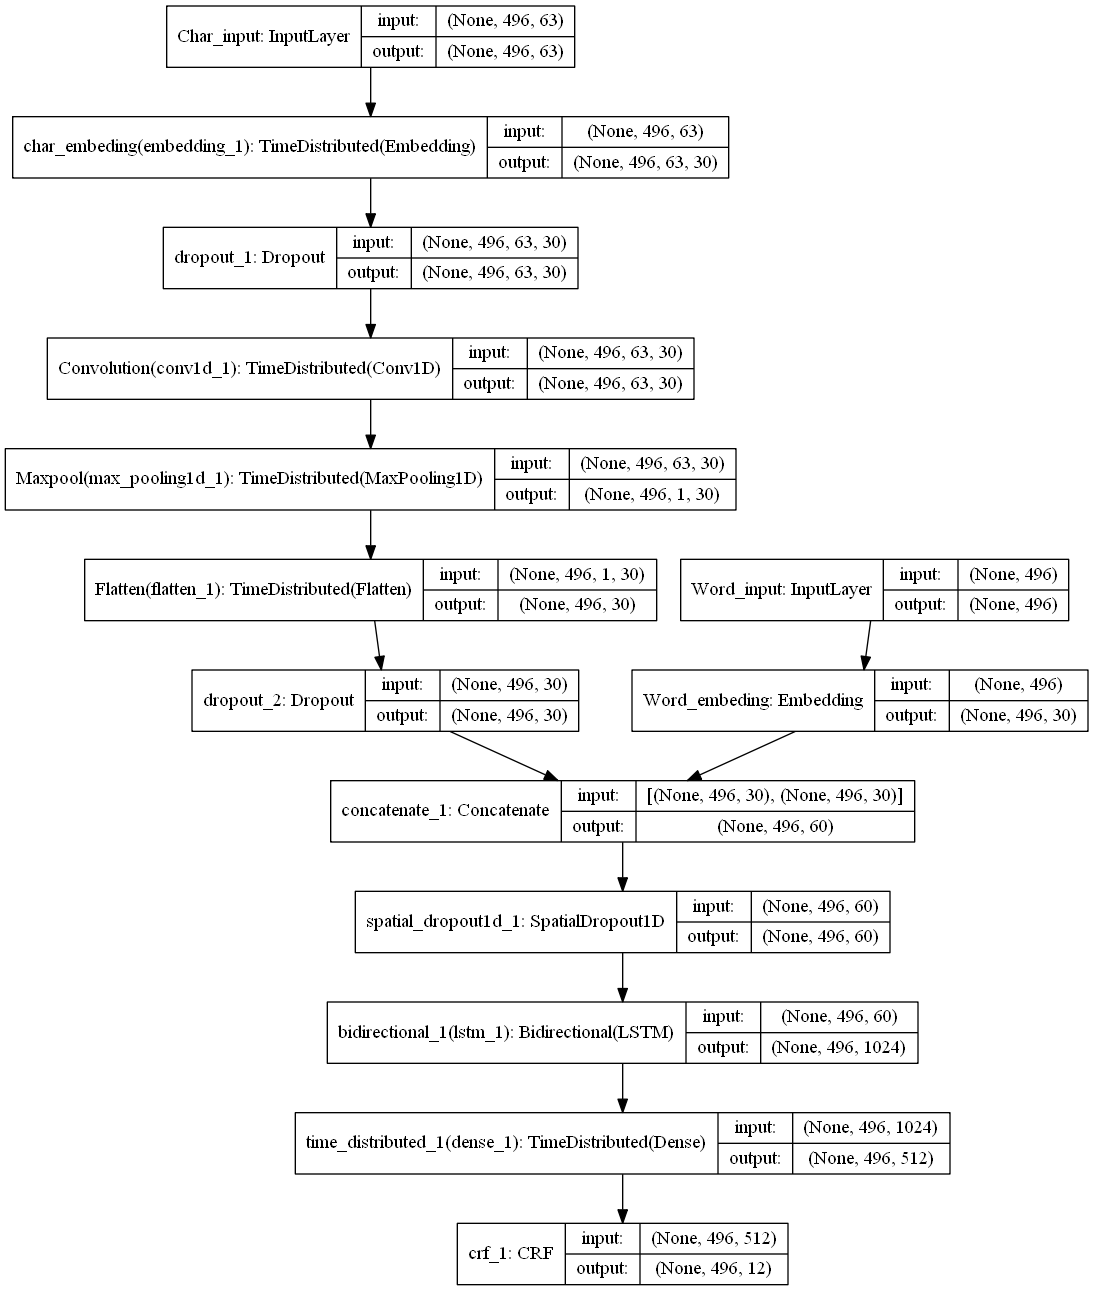

In [14]:
model.compile(optimizer="adam", loss=crf.loss_function, metrics=[crf.accuracy])
from IPython.display import Image 
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image('model.png')

In [15]:
np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char)).shape

(1140, 496, 63)

In [16]:
np.array(y_tr).reshape(len(y_tr), max_len, 1).shape

(1140, 496, 1)

In [17]:
X_word_tr.shape

(1140, 496)

In [18]:
max_len, max_len_char

(496, 63)

In [19]:
log_dir = r"./logs/ltsm_cnn_crf"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
from keras.callbacks import ModelCheckpoint
checkpoint_filepath = r'./Models/checkpoint/ltsm.cnn.crf.weights.best.h5'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor='val_crf_viterbi_accuracy',mode='max',save_best_only=True)
callbacks_list = [model_checkpoint_callback,tensorboard_callback]

In [20]:
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())
history = model.fit([X_word_tr, np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],np.array(y_tr).reshape(len(y_tr), max_len, 1),batch_size=8, epochs=100, validation_split=0.11, verbose=1,callbacks=callbacks_list)


Train on 1014 samples, validate on 126 samples
Epoch 1/100
1014/1014 [==============================] - 526s 519ms/step - loss: 1.6849 - crf_viterbi_accuracy: 0.2876 - val_loss: 1.3771 - val_crf_viterbi_accuracy: 0.3214
Epoch 2/100
1014/1014 [==============================] - 537s 530ms/step - loss: 1.1637 - crf_viterbi_accuracy: 0.2885 - val_loss: 0.9450 - val_crf_viterbi_accuracy: 0.3234
Epoch 3/100
1014/1014 [==============================] - 519s 512ms/step - loss: 0.7932 - crf_viterbi_accuracy: 0.2894 - val_loss: 0.6479 - val_crf_viterbi_accuracy: 0.3234
Epoch 4/100
1014/1014 [==============================] - 496s 490ms/step - loss: 0.5517 - crf_viterbi_accuracy: 0.6620 - val_loss: 0.4738 - val_crf_viterbi_accuracy: 0.6483
Epoch 5/100
1014/1014 [==============================] - 496s 489ms/step - loss: 0.4196 - crf_viterbi_accuracy: 0.6818 - val_loss: 0.3800 - val_crf_viterbi_accuracy: 0.6483
Epoch 6/100
1014/1014 [==============================] - 499s 492ms/step - loss: 0.3517

Epoch 47/100
1014/1014 [==============================] - 481s 475ms/step - loss: 0.1140 - crf_viterbi_accuracy: 0.6814 - val_loss: 0.1150 - val_crf_viterbi_accuracy: 0.6483
Epoch 48/100
1014/1014 [==============================] - 481s 475ms/step - loss: 0.1134 - crf_viterbi_accuracy: 0.6817 - val_loss: 0.1145 - val_crf_viterbi_accuracy: 0.6483
Epoch 49/100
1014/1014 [==============================] - 480s 474ms/step - loss: 0.1129 - crf_viterbi_accuracy: 0.6817 - val_loss: 0.1137 - val_crf_viterbi_accuracy: 0.6483
Epoch 50/100
1014/1014 [==============================] - 481s 474ms/step - loss: 0.1123 - crf_viterbi_accuracy: 0.6818 - val_loss: 0.1133 - val_crf_viterbi_accuracy: 0.6483
Epoch 51/100
1014/1014 [==============================] - 481s 474ms/step - loss: 0.1118 - crf_viterbi_accuracy: 0.6816 - val_loss: 0.1128 - val_crf_viterbi_accuracy: 0.6483
Epoch 52/100
1014/1014 [==============================] - 481s 474ms/step - loss: 0.1114 - crf_viterbi_accuracy: 0.6826 - val_loss

In [ ]:
model.save(r'./Models/ltsmCNNCRFModel')
model_json = model.to_json()
with open("./Models/ltsmCNNCRFModel.json", "w") as json_file:
    json_file.write(model_json)